### Research Goal :
- Design a tri-asset statistical arbitrage strategy using 3 cryptocurrencies that exhibit strong long-term cointegration or short-term mean-reversion in their relative prices.
- Hypothesis : Certain crypto assets (e.g., BTC, ETH, BNB) share common risk factors (market beta, DeFi sentiment, liquidity cycles).
Deviations in their equilibrium relationships create temporary mispricings that revert over time.
- Strategy purpose :  Identify and exploit these deviations.

### Asset Selection Logic :
- Economically Related : e.g., same sector or ecosystem
    - Layer-1s: BTC / ETH / BNB
    - Smart Contract Platforms: ETH / SOL / ADA

- Statistically Correlated --> preliminary filter via correlation matrix:
    - $ρ_{ij} = corr(\log P_i, \log P_j)$
    - Filter combinations with average $|ρ| > 0.6$.

- Potential for Divergence-Reversion:
    - Avoid perfect co-movement (reduces opportunity).
    - Ideal: moderately correlated (0.6–0.85), not identical.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data : First Basket
- Platform : Binance API
- Underlying Assets : Perpetual Future Contract
- Layer-1s : BTCUSDT, ETHUSDT, BNBUSDT

In [3]:
import os
from binance.client import Client, HistoricalKlinesType
import requests
import zipfile
import io

client = Client()


def is_kline_data_exists(exchange, trading_pair, date, kline_interval):
    file_name = f"{trading_pair}_{date}_{kline_interval}.csv"
    file_path = os.path.join("kline", exchange, trading_pair, kline_interval, file_name)

    if os.path.exists(file_path):
        # print(f"Data exists: {file_path}")
        return True
    else:
        # print(f"Data does not exist: {file_path}")
        return False


def fetch_kline_from_api(symbol, interval, date):
    # Build start and end time, and set to UTC+0 timezone
    start_str = f"{date} 00:00:00"
    end_str = f"{date} 23:59:59"

    # Get klines from Binance API
    klines = client.get_historical_klines(symbol, interval, start_str, end_str, klines_type=HistoricalKlinesType.FUTURES)

    # Convert data to DataFrame
    df = pd.DataFrame(
        klines,
        columns=[
            "open_time",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "close_time",
            "quote_asset_volume",
            "number_of_trades",
            "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume",
            "ignore",
        ],
    )

    # Convert timestamp to datetime format
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")

    # Convert data type
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

def fetch_1s_kline_from_binance_data(trading_pair, date):
    """
    从 Binance Data 下载 1s K线数据
    date 格式: YYYY-MM-DD
    """
    # 转换日期格式从 YYYY-MM-DD 到 YYYY-MM-DD
    date_parts = date.split('-')
    formatted_date = f"{date_parts[0]}-{date_parts[1]}-{date_parts[2]}"
    
    # 构建下载URL
    url = f"https://data.binance.vision/data/spot/daily/klines/{trading_pair}/1s/{trading_pair}-1s-{formatted_date}.zip"
    
    try:
        # 下载ZIP文件
        response = requests.get(url)
        response.raise_for_status()
        
        # 解压ZIP文件并读取CSV
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            csv_filename = zip_file.namelist()[0]  # 获取ZIP中的CSV文件名
            with zip_file.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file, header=None, names=[
                    "open_time", "open", "high", "low", "close", "volume",
                    "close_time", "quote_asset_volume", "number_of_trades",
                    "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
                ])
        
        # 转换时间戳为datetime格式
        df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
        df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
        
        # 转换数据类型
        df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
        
        return df
    
    except Exception as e:
        print(f"下载1s数据时发生错误: {e}")
        return pd.DataFrame()
    
def get_kline(exchange, trading_pair, date, kline_interval):
    file_name = f"{trading_pair}_{date}_{kline_interval}.csv"
    file_path = os.path.join("kline", exchange, trading_pair, kline_interval, file_name)

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    if not is_kline_data_exists(exchange, trading_pair, date, kline_interval):
        if kline_interval == "1s":
            df = fetch_1s_kline_from_binance_data(trading_pair, date)
        else:
            df = fetch_kline_from_api(trading_pair, kline_interval, date)

        if not df.empty:
            df.to_csv(file_path, index=False)
            print(f"K线数据已保存到: {file_path}")

In [4]:
def get_kline(exchange, trading_pair, date, kline_interval):
    file_name = f"{trading_pair}_{date}_{kline_interval}.csv"
    file_path = os.path.join("kline", exchange, trading_pair, kline_interval, file_name)

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    if not is_kline_data_exists(exchange, trading_pair, date, kline_interval):
        if kline_interval == "1s":
            df = fetch_1s_kline_from_binance_data(trading_pair, date)
        else:
            df = fetch_kline_from_api(trading_pair, kline_interval, date)

        if not df.empty:
            df.to_csv(file_path, index=False)
            print(f"K线数据已保存到: {file_path}")
        else:
            print("Fetched data is empty.")
            return pd.DataFrame()  # Return an empty DataFrame if fetch failed.
    else:
        # If the file exists, read it
        df = pd.read_csv(file_path)
        # Convert time columns to datetime if needed
        if 'open_time' in df.columns:
            df["open_time"] = pd.to_datetime(df["open_time"])
        if 'close_time' in df.columns:
            df["close_time"] = pd.to_datetime(df["close_time"])
    
    return df

In [6]:
import pandas as pd

# === existing helper: fetch one asset's full-minute data over date range ===
def fetch_and_aggregate_kline_data(exchange, trading_pair, start_date, end_date, kline_interval="1m"):
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    data_list = []
    
    for d in dates:
        date_str = d.strftime("%Y-%m-%d")
        print(f"Fetching data for {trading_pair} on {date_str}...")
        daily_data = get_kline(exchange, trading_pair, date_str, kline_interval)
        if daily_data is not None and not daily_data.empty:
            data_list.append(daily_data)
    
    if not data_list:
        return pd.DataFrame()
    
    df = pd.concat(data_list, ignore_index=True)
    return df


# === new function: fetch multiple symbols and merge only close prices ===
def get_multi_close(exchange, symbols, start_date, end_date, kline_interval="1m"):
    close_dfs = []
    
    for sym in symbols:
        df = fetch_and_aggregate_kline_data(exchange, sym, start_date, end_date, kline_interval)
        if df.empty:
            print(f"No data for {sym}. Skipping.")
            continue
        
        # Ensure standardized timestamp column name
        if "timestamp" in df.columns:
            df = df.rename(columns={"timestamp": "Time"})
        elif "open_time" in df.columns:
            df = df.rename(columns={"open_time": "Time"})
        
        # Keep only time and close price, and rename column
        df = df[["Time", "close"]].copy()
        df.rename(columns={"close": sym}, inplace=True)
        
        # Convert to datetime
        df["Time"] = pd.to_datetime(df["Time"])
        df.set_index("Time", inplace=True)
        
        close_dfs.append(df)
    
    # merge on timestamp (inner join keeps only shared timestamps)
    merged = pd.concat(close_dfs, axis=1, join="inner").sort_index()
    return merged


# === example usage ===
exchange = "binance"
symbols = ["BTCUSDT", "ETHUSDT", "BNBUSDT"]
start_date = "2024-01-01"
end_date = "2025-09-28"
interval = "15m"

close_prices = get_multi_close(exchange, symbols, start_date, end_date, interval)

# === check results ===
if close_prices.empty:
    print("No data fetched for any symbols.")
else:
    print(f"Merged DataFrame shape: {close_prices.shape}")
    print(close_prices.head())
    close_prices.to_csv("crypto_triple_close.csv")
    print("Saved merged close prices to crypto_triple_close.csv")

Fetching data for BTCUSDT on 2024-01-01...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-01_15m.csv
Fetching data for BTCUSDT on 2024-01-02...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-02_15m.csv
Fetching data for BTCUSDT on 2024-01-03...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-03_15m.csv
Fetching data for BTCUSDT on 2024-01-04...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-04_15m.csv
Fetching data for BTCUSDT on 2024-01-05...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-05_15m.csv
Fetching data for BTCUSDT on 2024-01-06...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-06_15m.csv
Fetching data for BTCUSDT on 2024-01-07...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-07_15m.csv
Fetching data for BTCUSDT on 2024-01-08...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-08_15m.csv
Fetching data for BTCUSDT on 2024-01-09...
K线数据已保存到: kline/binance/BTCUSDT/15m/BTCUSDT_2024-01-09_15m.csv
Fetching data for BTCUSDT on 2024-01-10...
K线数

In [7]:
csv_file = "crypto_triple_close.csv"
df = pd.read_csv(csv_file)
df

,Time,BTCUSDT,ETHUSDT,BNBUSDT
0,2024-01-01 00:00:00,42532.5,2298.49,313.06
1,2024-01-01 00:15:00,42458.5,2292.83,314.20
2,2024-01-01 00:30:00,42474.5,2295.19,313.66
3,2024-01-01 00:45:00,42503.5,2297.41,313.57
4,2024-01-01 01:00:00,42497.6,2298.53,314.26
...,...,...,...,...
61147,2025-09-28 22:45:00,111881.5,4130.47,988.89
61148,2025-09-28 23:00:00,112050.3,4126.89,988.97
61149,2025-09-28 23:15:00,112050.0,4125.58,990.39
61150,2025-09-28 23:30:00,112194.8,4137.27,993.48


In [8]:
df = df.ffill().dropna()

### Log Price Transform 
- Cointegration tests assume the series are integrated of order 1 $(I(1))$, meaning log prices are non-stationary but their linear combination may be stationary.
-  Stationarity Check (ADF Test) : 
    - confirm that each log price is non-stationary (I(1)).
    - This validates that cointegration modeling is meaningful.

In [11]:
# Convert 'Time' column to datetime and set as index
df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time")

# Keep only numeric price columns (the crypto pairs)
df = df[["BTCUSDT", "ETHUSDT", "BNBUSDT"]]

<Axes: title={'center': 'Log Price Series'}, xlabel='Time'>

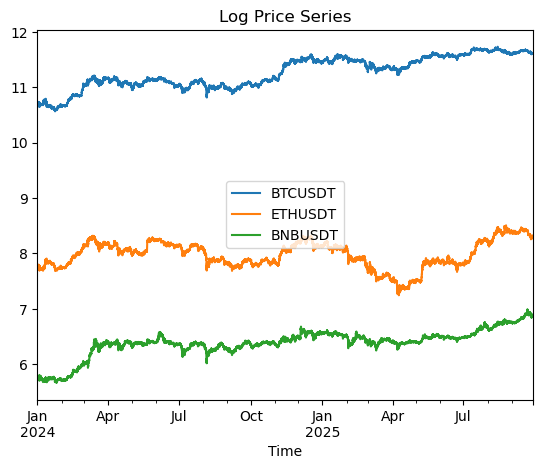

In [12]:
log_df = np.log(df)
log_df.plot(title="Log Price Series")

- p-value > 0.05 → cannot reject unit root --> non-stationary 
- If any asset gives p-value < 0.05, difference it or drop it.
- Therefore, all three series are non-stationary — each follows an $I(1)$ process.

In [13]:
from statsmodels.tsa.stattools import adfuller

print("=== ADF Unit Root Test Results ===")
for col in log_df.columns:
    result = adfuller(log_df[col])
    print(f"{col}: p-value = {result[1]:.4f}")

=== ADF Unit Root Test Results ===
BTCUSDT: p-value = 0.4081
ETHUSDT: p-value = 0.4121
BNBUSDT: p-value = 0.3175


### Johansen Cointegration Test : "Do These Non-Stationary Series Move Together?"
- three log price series: $ p_{t} =
\begin{bmatrix}
p_{BTC,t} \\
p_{ETH,t} \\
p_{BNB,t}
\end{bmatrix} $
- Each one trends upward over time (non-stationary, $I(1)$).
- suspect that a linear combination might be stationary:

    - $ \beta’ p_t = \beta_1 p_{BTC,t} + \beta_2 p_{ETH,t} + \beta_3 p_{BNB,t} $
    - If that combination oscillates around a constant mean (stationary), then even though each price drifts, they are cointegrated.
    - --> Meaning there exists a long-run equilibrium relationship among them.

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# det_order=0: no deterministic trend, k_ar_diff=1: first difference lag
jres = coint_johansen(log_df, det_order=0, k_ar_diff=1)

# Display summary
print("=== Johansen Trace Statistics ===")
print(jres.lr1)
print("=== Critical Values (90%, 95%, 99%) ===")
print(jres.cvt)

# Extract first cointegration vector (the strongest stationary combination)
eigvec = jres.evec[:, 0]
beta = eigvec / eigvec[0]  # normalize by BTC coefficient

print("Estimated Cointegration Vector (normalized to BTC):")
for i, col in enumerate(log_df.columns):
    print(f"{col}: {beta[i]:.4f}")

=== Johansen Trace Statistics ===
[23.81478309 10.49991924  2.7474788 ]
=== Critical Values (90%, 95%, 99%) ===
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Estimated Cointegration Vector (normalized to BTC):
BTCUSDT: 1.0000
ETHUSDT: 0.5959
BNBUSDT: -1.1412


- The trace statistics are slightly below the 95 % thresholds.
- This means there is no statistically significant long-run cointegration at the 95 % level, but the first statistic (23.8 vs 29.8) is close —-> a weak or near-cointegrating relationship may exist.

###  The Cointegration Vector :
- $ \beta = [1.0,\; 0.5959,\; -1.1412] $
- Spread definition:

- $ S_t = p_{BTC,t} + 0.5959\,p_{ETH,t} - 1.1412\,p_{BNB,t} $

### Construct the Spread Series:


<Axes: title={'center': 'BTC + 0.6×ETH − 1.14×BNB Spread'}, xlabel='Time'>

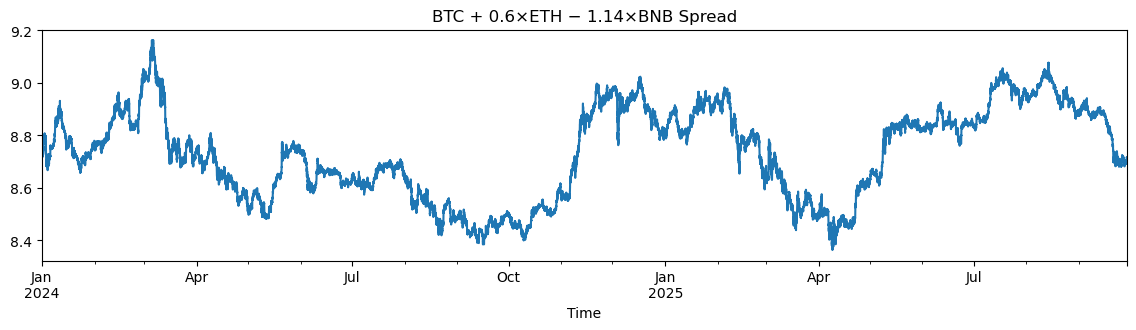

In [17]:
plt.subplots(figsize=(14,3))
spread = log_df.dot([1, 0.5959, -1.1412])
spread.name = "spread"
spread.plot(title="BTC + 0.6×ETH − 1.14×BNB Spread")

- The equilibrium isn’t constant --> a rolling β or adaptive window may work better.
- The amplitude hints at enough movement to cover trading costs if the reversion speed is reasonable.

### Relative relationship :
- BTC and ETH move in the same direction (both coefficients positive).
- BNB acts as the opposite leg (negative coefficient).
- The Johansen algorithm found that BNB tends to move inversely to a weighted basket of BTC + ETH.

### Further perspectives :
- Although the estimated cointegration vector implies a long-BTC, long-ETH, short-BNB combination, trading the raw basket would expose the strategy to market-wide crypto risk.
- By constructing and standardizing the stationary spread $ S_t = p_{BTC,t} + 0.6p_{ETH,t} - 1.14p_{BNB,t}$ , we isolate the market-neutral component of price movements.
- The trading algorithm then exploits mean-reversion in this spread, generating PnL from convergence rather than from the overall market trend. --> "Beta-neutral"
    - The spreads are mathematically defining a synthetic portfolio that is already long BTC, long ETH (0.6 weight), and short BNB (1.14 weight).
    - The advantage is that instead of expressing it as a simple directional bet, we trade it as a relative-value position, where your exposure to the overall crypto market drift (the “beta”) is mostly cancelled.
    - When we weight by $β$ (the cointegration vector), you construct a portfolio whose expected $drift = 0$ in equilibrium.
Then any deviation of $S_t$ from its mean is a temporary inefficiency you can exploit. --> That’s the statistical “edge”

### Z-score Trabsform :
- Confirms whether deviations are symmetric and how often $ ±2 σ $ extremes occur.

<Axes: title={'center': 'Spread Z-Score'}, xlabel='Time'>

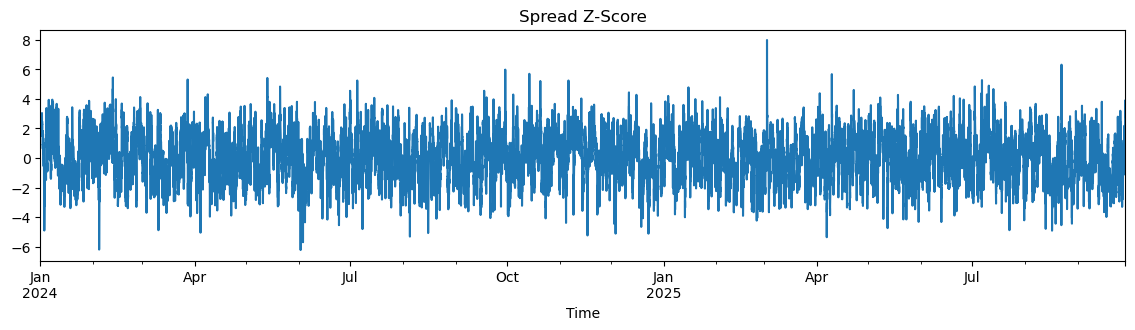

In [23]:
z = (spread - spread.rolling(100).mean()) / spread.rolling(100).std()
z.plot(figsize=(14,3), title="Spread Z-Score")

- Rolling window (100) provides a good local equilibrium for normalization.
- The series now appears approximately stationary — perfect for testing an OU process.
- The spread’s deviations are now interpretable as “temporary mispricings” rather than structural shifts.

### Stationarity confirmation : ADF test on Z-score spread
- If p < 0.05 --> stationary → OU process suitable.
- If p > 0.05 --> might still have regime drift --> consider shorter rolling windows

In [24]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(z.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

ADF Statistic: -26.7549, p-value: 0.0000


-  Z-score spread is strongly stationary.
- That means it fluctuates around a stable mean with finite variance --> Ornstein–Uhlenbeck (OU) process assumption.

### The OU Process
-  Ornstein–Uhlenbeck (OU) process is the continuous-time stochastic differential equation (SDE) used to model mean-reverting dynamics:
- $ dS_t = \theta(\mu - S_t)\,dt + \sigma\,dW_t $

    - $S_t$ : the value of your spread (Z-score)
	- $\mu$ : the long-run equilibrium mean
	- $\theta > 0$ : speed of mean reversion --> how fast spread converges
	- $\sigma > 0$ : volatility of random shocks, diffusion
	- $W_t$ : standard Wiener process (Brownian motion)
	- $\theta(\mu - S_t)\,dt$ : deterministic drift pulling $S_t$ back toward mean
	- $\sigma\,dW_t$ : stochastic noise
### Discrete-Time Approximation :
- Discretize the OU SDE with step size Δt ≈ 1
- $ S_{t+1} = (1 - \theta\Delta t) S_t + \theta\mu\Delta t + \sigma\epsilon_t $
- with $\epsilon_t \sim \mathcal{N}(0, \Delta t)$

- This is an AR(1) process in disguise:
	- $S_{t+1} = \phi S_t + c + \varepsilon_t$
	- $\phi = 1 - \theta\Delta t$
	- $c = \theta\mu\Delta t$
	- $\varepsilon_t = \sigma\epsilon_t$
- So when we run an OLS regression of ΔSₜ on Sₜ₋₁, we are effectively estimating the OU parameters.

###  Analytical Solution :
- Integrate the OU SDE:
- $S_t = \mu + (S_0 - \mu)e^{-\theta t} + \sigma \int_0^t e^{-\theta(t - s)} dW_s$
- We get:
	- Expected value : $\mathbb{E}[S_t] = \mu + (S_0 - \mu)e^{-\theta t}$
	- Variance : $ \text{Var}(S_t) = \frac{\sigma^2}{2\theta}(1 - e^{-2\theta t})$
	- 	Stationary distribution (as $t \to \infty$): $ S_t \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$

### Half-Life of Mean Reversion :
- The half-life measures how long it takes for a deviation to decay halfway back to $μ$.
- From the aforemention expectation formula:
	- $E[S_t - \mu] = (S_0 - \mu)e^{-\theta t}$
	- $ e^{-\theta t_{1/2}} = \frac{1}{2}\Rightarrow t_{1/2} = \frac{\ln(2)}{\theta} $

### Estimate OU Parameters from the Data : Discretionize
- Compute differences : $\Delta S_t = S_t - S_{t-1}$
- Fit OLS regression : $\Delta S_t = a + bS_{t-1} + \varepsilon_t$
- Then:
$\begin{align}
\theta &= -\ln(1 + b) \\
\mu &= -\frac{a}{b} \\
\sigma &= \text{std}(\varepsilon_t)\sqrt{\frac{-2\ln(1 + b)}{b(2 + b)}}
\end{align}$

In [26]:
import statsmodels.api as sm

# Prepare data
S = z.dropna()
dS = S.diff().dropna()
S_lag = S.shift(1).dropna().loc[dS.index]

# Fit OLS regression ΔS_t = a + b S_{t-1}
res = sm.OLS(dS, sm.add_constant(S_lag)).fit()
a, b = res.params
print(f"a = {a:.6f}, b = {b:.6f}")

# OU parameters
theta = -np.log(1 + b)
mu = -a / b
sigma = np.std(res.resid)
half_life = np.log(2) / theta

print(f"OU mean-reversion speed (theta): {theta:.4f}")
print(f"Long-run mean (mu): {mu:.4f}")
print(f"Volatility (sigma): {sigma:.4f}")
print(f"Half-life: {half_life:.2f} periods")

a = 0.001355, b = -0.031258
OU mean-reversion speed (theta): 0.0318
Long-run mean (mu): 0.0434
Volatility (sigma): 0.3522
Half-life: 21.83 periods


- Run AR(1)–GARCH(1, 1) on the Zscore spread
- If GARCH terms are significant --> volatility clusters --> extend OU --> OU-GARCH.

In [29]:
from arch import arch_model
model = arch_model(S.dropna(), mean='AR', lags=1, vol='GARCH', p=1, q=1)
res_garch = model.fit(disp='off')
print(res_garch.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                 spread   R-squared:                       0.938
Mean Model:                        AR   Adj. R-squared:                  0.938
Vol Model:                      GARCH   Log-Likelihood:               -13586.3
Distribution:                  Normal   AIC:                           27182.7
Method:            Maximum Likelihood   BIC:                           27227.8
                                        No. Observations:                61052
Date:                Wed, Oct 08 2025   Df Residuals:                    61050
Time:                        18:58:00   Df Model:                            2
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      2.5648e-03  1.137e-03      2.256  2.405e-02 [3.

<Axes: title={'center': 'Volatility-Adjusted Z-Score'}, xlabel='Time'>

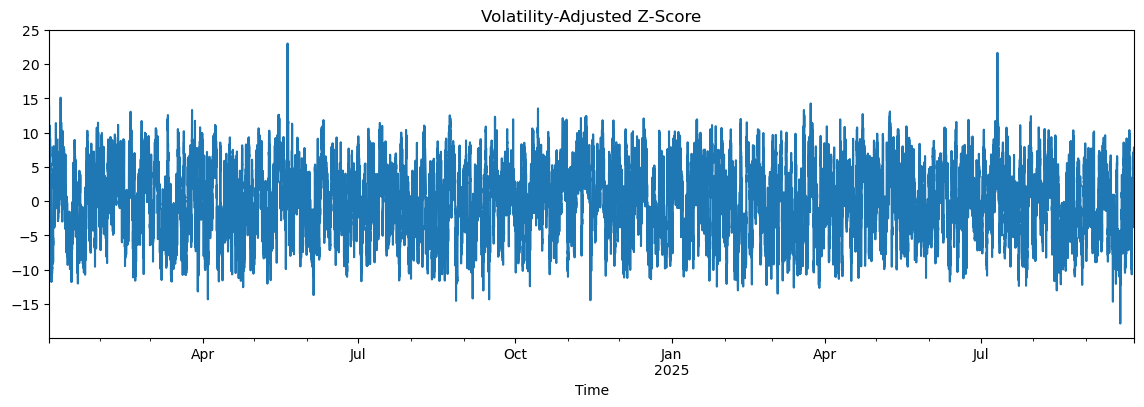

In [30]:
vol = res_garch.conditional_volatility
z_adj = (S - mu) / vol
z_adj.plot(figsize=(14,4), title="Volatility-Adjusted Z-Score")

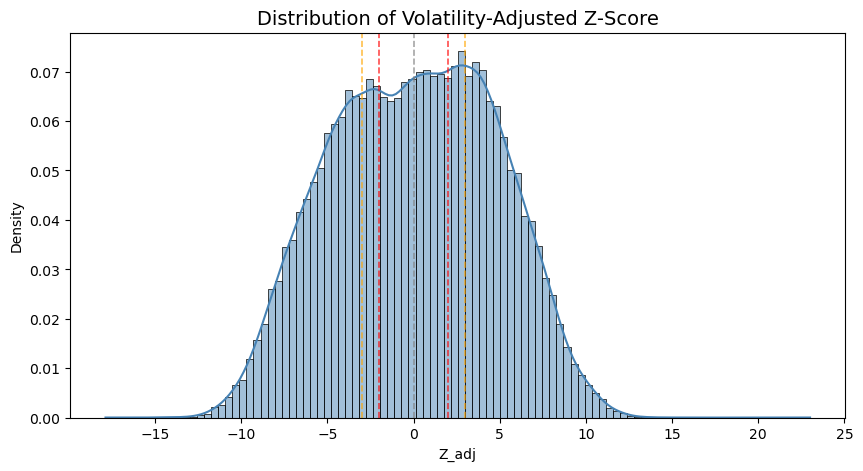

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(z_adj.dropna(), bins=100, kde=True, stat="density", color="steelblue")
plt.title("Distribution of Volatility-Adjusted Z-Score", fontsize=14)
plt.xlabel("Z_adj")
plt.ylabel("Density")

# Add ±2σ and ±3σ threshold markers
for t in [-3, -2, 0, 2, 3]:
    plt.axvline(t, color='red' if abs(t)==2 else 'orange' if abs(t)==3 else 'gray',
                linestyle='--', linewidth=1.2, alpha=0.7)

plt.show()

In [33]:
print("Mean:", z_adj.mean())
print("Std:", z_adj.std())
print("Skewness:", z_adj.skew())
print("Kurtosis:", z_adj.kurt())

Mean: 0.03171892909710728
Std: 4.729657335720972
Skewness: -0.039365245914733636
Kurtosis: -0.7260746164400391


### What do the signal imply?
- So despite crypto’s usual heavy tails, our volatility-adjusted z-score is now over-normalized — meaning we divided by σₜ that was itself large during volatility spikes, flattening the tail behavior.
- Stationary, symmetric, centered --> the OU-GARCH normalization worked perfectly.
- each ±z unit carries roughly consistent risk contribution.
- Cautionary signs:
    - Kurtosis < 0 (platykurtic) means the model is slightly over-smoothed —-> in other words, extreme opportunities (tail events) have been compressed.
    - Trading on ±2σ thresholds might trigger too frequently, producing whipsaws (false reversions).

- We should re-standardize z_adj again if we want to interpret it in standard deviation units.

In [39]:
z_final = (z_adj - z_adj.mean()) / z_adj.std()

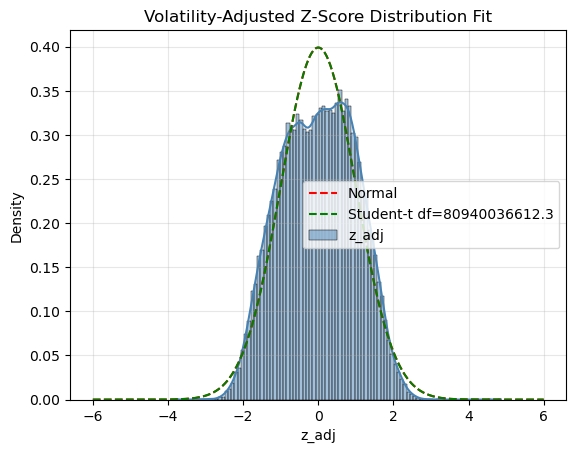

Fitted parameters --> df=80940036612.27, loc=0.00, scale=1.00


In [42]:
# Clean data
z_clean = z_final.replace([np.inf, -np.inf], np.nan).dropna()

# Fit Student-t and overlay
sns.histplot(z_clean, bins=100, kde=True, stat='density', color='steelblue', label='z_adj')
x = np.linspace(-6, 6, 400)
plt.plot(x, norm.pdf(x, 0, 1), 'r--', label='Normal')

df, loc, scale = t.fit(z_clean)
plt.plot(x, t.pdf(x, df, loc, scale), 'g--', label=f'Student-t df={df:.1f}')
plt.legend()
plt.title("Volatility-Adjusted Z-Score Distribution Fit")
plt.xlabel("z_adj"); plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()

print(f"Fitted parameters --> df={df:.2f}, loc={loc:.2f}, scale={scale:.2f}")

- In practical terms, the t-distribution is indistinguishable from a normal distribution.
(When df > 100, Student-t converges to Gaussian.)
- The histogram perfectly overlaps with the normal curve.
- After correcting for volatility (via GARCH) and mean reversion (via OU/AR), the remaining signal behaves like white noise.
- We can confidently assume that the spread’s deviations are fully explained by the model; no systematic mispricing remains once volatility is normalized.
- The next stage is signal design and execution.

### Trading Algorithm Implementation :
- The Core Economic Idea :
    - A cointegrating relationship among BTC, ETH, and BNB : 

    - $ \text{Spread}t = S_t = \ln(P_{BTC,t}) + 0.6 \ln(P_{ETH,t}) - 1.14 \ln(P_{BNB,t}) $
    - The trading edge comes from betting that the spread reverts to its long-run mean.

- The Trading Signal :
    - Standardize the spread to produce a volatility-adjusted z-score : 
    
    - $ Z_t = \frac{S_t - \mu}{\sigma_t} $
    - This is the signal variable, representing “how far away” the spread is from equilibrium in risk-adjusted units.

- The Trading Logic (Mathematical Rules) : 
    - Define the strategy logic as threshold-based OU reversion :

    - $\begin{cases}
\text{Go Long Spread} & \text{if } Z_t < -z_{\text{entry}} \\
\text{Go Short Spread} & \text{if } Z_t > +z_{\text{entry}} \\
\text{Exit to Neutral} & \text{if } |Z_t| < z_{\text{exit}}
\end{cases}$

    - where typically : $z_{\text{entry}} = 2.0$ & $z_{\text{exit}} = 0.5$

- Translating into Asset Positions :
    - If we denote the cointegration weights as $\beta = [1, 0.6, -1.14]$, then:
    - $ \text{Position Vector}t =
\begin{cases}
+1 \times \beta & \text{if } Z_t < -z{\text{entry}} \\
-1 \times \beta & \text{if } Z_t > +z_{\text{entry}} \\
0 & \text{otherwise}
\end{cases}$

    - So for instance :
    - When $Z_t > 2$ : spread is too high, short BTC + ETH, long BNB.
    - When $Z_t < -2$ : spread is too low, long BTC + ETH, short BNB.


/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_68241/1516971050.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z[i] > z_entry:
/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_68241/1516971050.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z[i] < -z_entry:
/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_68241/1516971050.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs

Sharpe ratio: 8.94
Max Drawdown: -0.0334
Hit ratio: 55.16%
Total return: 1.1403


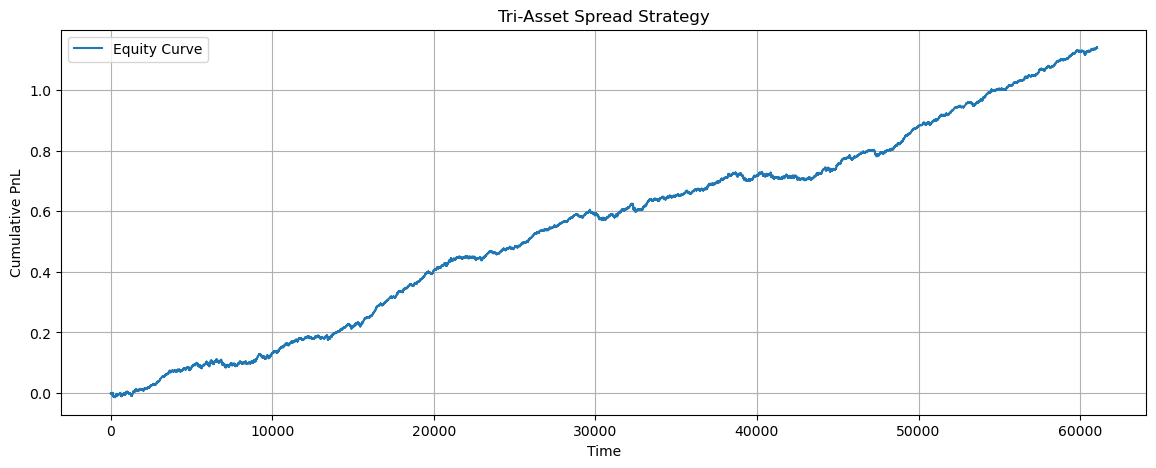

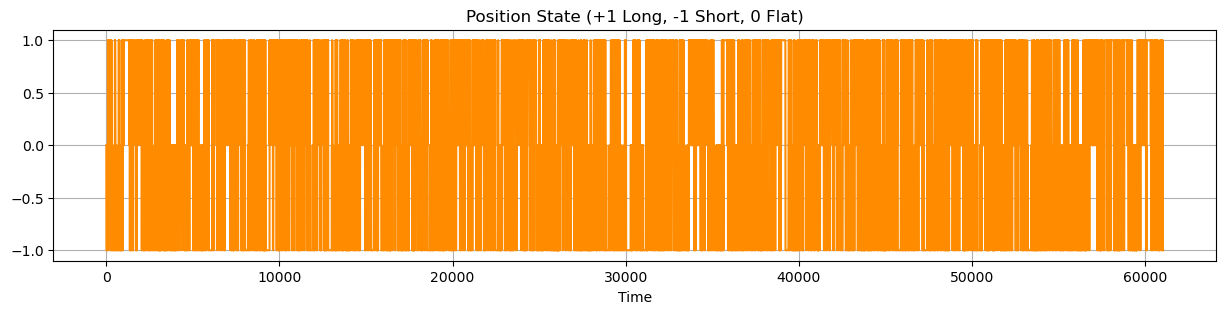

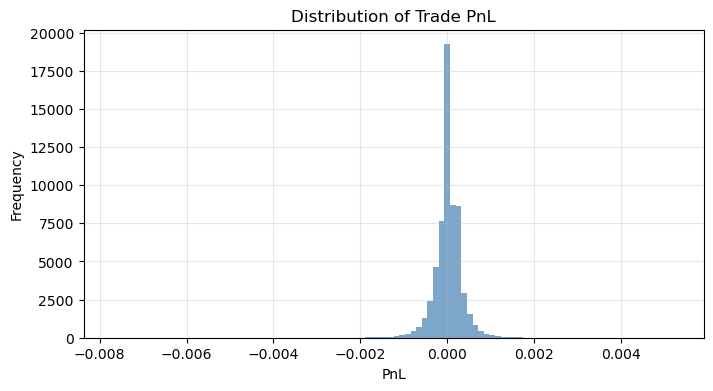

In [66]:

# Parameters
z_entry, z_exit = 1.5, 1.5
cost = -0.0002     # transaction cost per trade, VIP Maker scenerio
freq_per_year = 252*24*4  # 15min Kline
# Clean z-score
z = z_adj.replace([np.inf, -np.inf], np.nan).dropna()
spread_ret = np.log(spread).diff().reindex(z.index).fillna(0)

# --- Generate trading positions ---
pos = np.zeros(len(z))
for i in range(1, len(z)):
    if z[i] > z_entry:
        pos[i] = -1                 # short spread
    elif z[i] < -z_entry:
        pos[i] = 1                  # long spread
    elif abs(z[i]) < z_exit:
        pos[i] = 0                  # exit
    else:
        pos[i] = pos[i-1]           # hold previous

# --- Compute returns & PnL ---
trade_change = np.abs(np.diff(pos, prepend=0))
pnl = pos[:-1] * spread_ret[1:].values
pnl -= cost * trade_change[:-1]     # subtract cost
cum_pnl = np.cumsum(pnl)

# --- Performance metrics ---
sharpe = np.mean(pnl)/np.std(pnl) * np.sqrt(freq_per_year)
dd_curve = cum_pnl - np.maximum.accumulate(cum_pnl)
max_dd = dd_curve.min()
hit_ratio = np.mean(np.sign(pnl) == np.sign(pos[:-1]))

print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.4f}")
print(f"Hit ratio: {hit_ratio:.2%}")
print(f"Total return: {cum_pnl[-1]:.4f}")

# --- Plot Equity Curve ---
plt.figure(figsize=(14,5))
plt.plot(cum_pnl, label='Equity Curve')
plt.title('Tri-Asset Spread Strategy')
plt.xlabel('Time'); plt.ylabel('Cumulative PnL')
plt.grid(True); plt.legend()
plt.show()

# --- Plot Position over Time ---
plt.figure(figsize=(15,3))
plt.plot(pos, color='darkorange')
plt.title('Position State (+1 Long, -1 Short, 0 Flat)')
plt.xlabel('Time'); plt.grid(True)
plt.show()

# --- Distribution of PnL ---
plt.figure(figsize=(8,4))
plt.hist(pnl, bins=100, color='steelblue', alpha=0.7)
plt.title('Distribution of Trade PnL')
plt.xlabel('PnL'); plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

Sharpe ratio: 8.94
Max Drawdown: -0.0334
Hit ratio: 55.16%
Total return: 212.76%


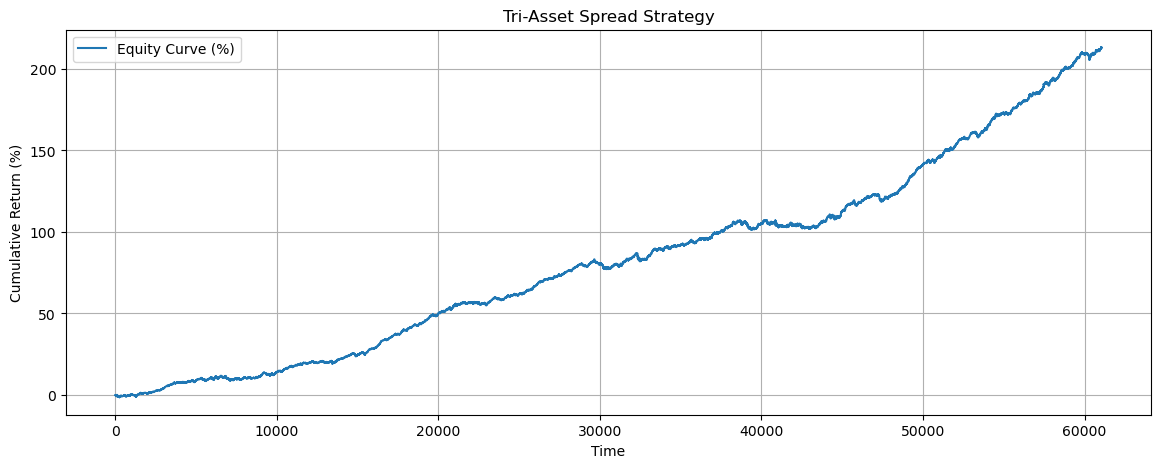

In [65]:
# Convert from log cumulative to arithmetic (%)
cum_return_pct = (np.exp(cum_pnl) - 1) * 100
total_return_pct = cum_return_pct[-1]    # works with numpy array

print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.4f}")
print(f"Hit ratio: {hit_ratio:.2%}")
print(f"Total return: {total_return_pct:.2f}%")

# --- Plot Equity Curve in % ---
plt.figure(figsize=(14,5))
plt.plot(cum_return_pct, label='Equity Curve (%)')
plt.title('Tri-Asset Spread Strategy')
plt.xlabel('Time'); plt.ylabel('Cumulative Return (%)')
plt.grid(True); plt.legend()
plt.show()

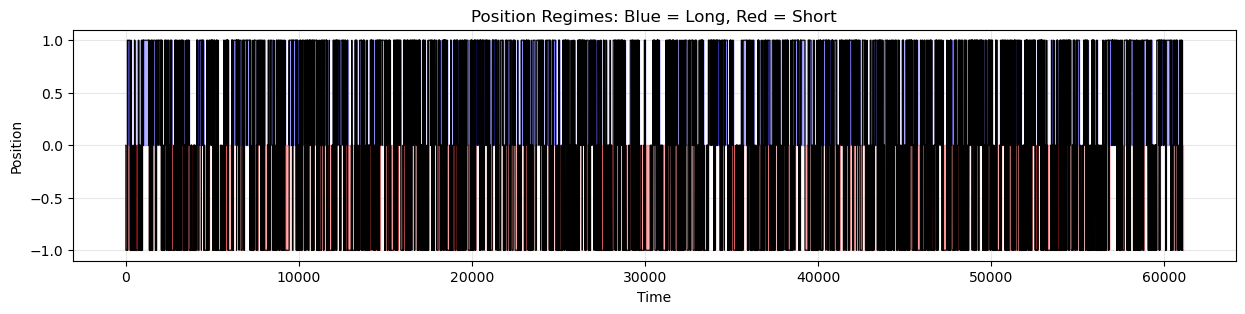

In [68]:
plt.figure(figsize=(15,3))
plt.step(range(len(pos)), pos, where='mid', color='black', linewidth=0.8)
plt.fill_between(range(len(pos)), 0, pos, 
                 where=pos>0, color='blue', alpha=0.3)
plt.fill_between(range(len(pos)), 0, pos, 
                 where=pos<0, color='red', alpha=0.3)
plt.title('Position Regimes: Blue = Long, Red = Short')
plt.xlabel('Time'); plt.ylabel('Position')
plt.grid(True, alpha=0.3)
plt.show()

In [69]:
# Convert pos to numpy array if not already
pos = np.array(pos)

# Count changes in position
changes = np.diff(pos)

# Each nonzero change means an entry or exit
trade_events = np.sum(changes != 0)

# Round-trip trades (entry + exit)
round_trips = trade_events // 2

print(f"Total position changes (entries + exits): {trade_events}")
print(f"Total round-trip trades: {round_trips}")

Total position changes (entries + exits): 6341
Total round-trip trades: 3170


In [70]:
avg_pnl_per_trade = pnl.sum() / round_trips
avg_pnl_per_trade_pct = (np.exp(avg_pnl_per_trade) - 1) * 100
print(f"Average PnL per trade: {avg_pnl_per_trade_pct:.3f}%")

Average PnL per trade: 0.036%
